In [1]:
%load_ext line_profiler

In [2]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import (
    states,
    hamiltonian,
    couplings,
    transitions,
    lindblad,
    constants,
    utils,
)

plt.rcParams.update({"font.size": 14})


In [3]:
trans = [
    transitions.OpticalTransition(
        t=transitions.OpticalTransitionType.P, J_ground=2, F1_excited=3 / 2, F_excited=1
    ),
    transitions.MicrowaveTransition(J_ground=2, J_excited=1),
    transitions.MicrowaveTransition(J_ground=2, J_excited=3),
]
transition_selectors = couplings.generate_transition_selectors(
    transitions=trans,
    polarizations=[
        [couplings.polarization_Z],
        [couplings.polarization_σm, couplings.polarization_σp],
        [couplings.polarization_σm, couplings.polarization_σp],
    ],
)


In [4]:
couplings.utils.ΔmF_allowed(polarization=couplings.polarization_σm.vector)

-1

In [5]:
H_reduced = hamiltonian.generate_reduced_hamiltonian_transitions(transitions=trans)


In [6]:
coupling = []
for transition_selector in transition_selectors:
    coupling.append(
        couplings.generate_coupling_field_automatic(
            transition_selector.ground,
            transition_selector.excited,
            H_reduced.QN_basis,
            H_reduced.H_int,
            H_reduced.QN,
            H_reduced.V_ref_int,
            pol_vecs=transition_selector.polarizations,
        )
    )


In [7]:
C_array = couplings.collapse_matrices(
    H_reduced.QN,
    H_reduced.X_states,
    H_reduced.B_states,
    gamma=constants.Γ,
    qn_compact=None,
)


In [8]:
H_symbolic = lindblad.generate_total_symbolic_hamiltonian(
    H_reduced.QN, H_reduced.H_int, coupling, transition_selectors
)


In [9]:
ham, dissipator = lindblad.generate_system_of_equations_symbolic(
    H_symbolic, C_array, fast=True, split_output=True
)


In [12]:
C_array = C_array.astype(np.float64)

In [13]:
from scipy.linalg import blas

In [14]:
rho = np.ascontiguousarray(np.zeros(ham.shape, dtype=np.complex128))
rho[-1, -1] = 1.0


In [15]:
def lindblad_rhs(t, rho, H, jump_ops):
    """
    Compute the right-hand side of the Lindblad master equation.

    The Lindblad equation is given by:

        dρ/dt = -i [H, ρ] + Σ_j ( L_j ρ L_j† - 0.5 {L_j† L_j, ρ} )

    where:
      - ρ is the density matrix,
      - H is the Hamiltonian,
      - jump_ops is a list (or array) of jump operators L_j.

    Parameters:
    -----------
    t : float
        Time (can be used for time-dependent Hamiltonians or jump operators).
    rho : np.ndarray
        The density matrix (should be a square matrix).
    H : np.ndarray
        The Hamiltonian operator (same dimensions as rho).
    jump_ops : list of np.ndarray
        A list of jump operators.

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """
    # Compute the unitary (Hamiltonian) part: -i[H, ρ]
    commutator = -1j * (np.dot(H, rho) - np.dot(rho, H))

    # Initialize the dissipator (dissipative part)
    dissipator = np.zeros_like(rho, dtype=complex)

    # Loop over all jump operators
    for L in jump_ops:
        # L ρ L† term
        L_rho = np.dot(L, rho)
        dissipator += np.dot(L_rho, L.conj().T)

        # -1/2 {L† L, ρ} term
        L_dagL = np.dot(L.conj().T, L)
        dissipator -= 0.5 * (np.dot(L_dagL, rho) + np.dot(rho, L_dagL))

    return commutator + dissipator


In [16]:
%%timeit
lindblad_rhs(0.0, rho, H_reduced.H_int, C_array)


24.4 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def lindblad_rhs(t, rho, H, jump_ops):
    """
    Compute the right-hand side of the Lindblad master equation, taking
    advantage of the Hermitian nature of the density matrix and Hamiltonian
    using specialized BLAS routines.

    The Lindblad equation is:

        dρ/dt = -i [H, ρ] + ∑_j (L_j ρ L_j† - 0.5 {L_j† L_j, ρ})

    Parameters:
    -----------
    t : float
        Time (included for ODE solver compatibility).
    rho : np.ndarray
        Density matrix (should be Hermitian).
    H : np.ndarray
        Hamiltonian (should be Hermitian).
    jump_ops : list of np.ndarray
        List of jump operators L_j.

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """
    # Compute the commutator: -i[H, ρ]
    commutator = -1j * (
        blas.zhemm(alpha=1.0, a=H, b=rho, side=0, lower=1)
        - blas.zhemm(alpha=1.0, a=H, b=rho, side=1, lower=1)
    )

    # Compute the dissipative part
    dissipator = np.zeros_like(rho, dtype=complex)
    for L in jump_ops:
        dissipator += L @ rho @ L.conj().T
        dissipator -= 0.5 * (L.conj().T @ L @ rho + rho @ L.conj().T @ L)

    return commutator + dissipator


In [18]:
%%timeit
lindblad_rhs(0.0, rho, H_reduced.H_int, C_array)


25.4 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
C_array = np.ascontiguousarray(C_array)
jump_ops_precompute = np.ascontiguousarray([L.conj().T @ L for L in C_array])


def lindblad_rhs(t, rho, H, jump_ops, LdagL_precompute):
    """
    Compute the right-hand side of the Lindblad master equation, taking
    advantage of the Hermitian nature of the density matrix and Hamiltonian
    using specialized BLAS routines.

    The Lindblad equation is:

        dρ/dt = -i [H, ρ] + ∑_j (L_j ρ L_j† - 0.5 {L_j† L_j, ρ})

    Parameters:
    -----------
    t : float
        Time (included for ODE solver compatibility).
    rho : np.ndarray
        Density matrix (should be Hermitian).
    H : np.ndarray
        Hamiltonian (should be Hermitian).
    jump_ops : list of np.ndarray
        List of jump operators L_j.

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """
    # Use zhemm for efficient multiplication with Hermitian H.
    # For zhemm:
    #  - side='L' multiplies H on the left: H @ rho.
    #  - side='R' multiplies H on the right: rho @ H.
    # The 'lower' flag tells zhemm which triangular part of H to use; if H is fully stored
    # and symmetric, either can be used (here we choose the lower triangle).
    # H_rho = blas.zhemm(alpha=1.0, a=H, b=rho, side=0, lower=1)
    # rho_H = blas.zhemm(alpha=1.0, a=H, b=rho, side=1, lower=1)

    # Compute the commutator: -i[H, ρ]
    # commutator = -1j * (H_rho - rho_H)
    commutator = -1j * (np.dot(H, rho) - np.dot(rho, H))

    # Compute the dissipative part
    dissipator = np.zeros_like(rho, dtype=complex)
    for L, LdagL in zip(jump_ops, LdagL_precompute):
        dissipator += L @ rho @ L.conj().T
        dissipator -= 0.5 * (LdagL @ rho + rho @ LdagL)

    return commutator + dissipator


In [20]:
%%timeit
lindblad_rhs(0.0, rho, H_reduced.H_int, C_array, jump_ops_precompute)


20.4 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
def lindblad_rhs_vectorized(t, rho, H, jump_ops, Ldag, LdagL):
    """
    Compute the right-hand side of the Lindblad master equation in a vectorized manner,
    eliminating explicit Python loops over jump operators.

    The Lindblad equation is:
        dρ/dt = -i [H, ρ] + Σ_j (L_j ρ L_j† - 0.5 {L_j†L_j, ρ})

    Parameters:
    -----------
    t : float
        Time variable (for ODE solver compatibility).
    rho : np.ndarray
        Density matrix (assumed Hermitian).
    H : np.ndarray
        Hamiltonian (assumed Hermitian).
    jump_ops : list of np.ndarray
        List of jump operators L_j.

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """
    # Compute the Hamiltonian part: -i[H, ρ]
    commutator = -1j * (H @ rho - rho @ H)

    # Compute the first term: Σ_j L_j ρ L_j†
    # The operation L @ rho multiplies each L_j by rho (resulting shape (n, M, M))
    # Then (L @ rho) @ L†, where L† is L.conj().transpose(0, 2, 1), yields an array of shape (n, M, M)
    term1 = np.sum(jump_ops @ rho @ Ldag, axis=0)

    # Compute the second term: 0.5 Σ_j (L_j† L_j ρ + ρ L_j† L_j)
    # First compute L_j† L_j for each jump operator.
    term2 = 0.5 * (np.sum(LdagL @ rho, axis=0) + np.sum(rho @ LdagL, axis=0))

    # The dissipative part is term1 - term2.
    dissipator = term1 - term2

    return commutator + dissipator


In [22]:
LdagL_old = np.einsum("nij,njk->nik", C_array.conj().transpose(0, 2, 1), C_array)

L_dag = C_array.conj().transpose(0, 2, 1)
LdagL = np.ascontiguousarray(L_dag @ C_array)  # shape: (n, M, M)


In [23]:
%%timeit
lindblad_rhs_vectorized(0.0, rho, H_reduced.H_int, C_array, L_dag, LdagL)


21.9 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%lprun -f lindblad_rhs_vectorized lindblad_rhs_vectorized(0.0, rho, H_reduced.H_int, C_array, L_dag, LdagL)

Timer unit: 1e-07 s

Total time: 0.0276567 s
File: C:\Users\ogras\AppData\Local\Temp\ipykernel_49084\691604963.py
Function: lindblad_rhs_vectorized at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def lindblad_rhs_vectorized(t, rho, H, jump_ops, Ldag, LdagL):
     2                                               """
     3                                               Compute the right-hand side of the Lindblad master equation in a vectorized manner,
     4                                               eliminating explicit Python loops over jump operators.
     5                                           
     6                                               The Lindblad equation is:
     7                                                   dρ/dt = -i [H, ρ] + Σ_j (L_j ρ L_j† - 0.5 {L_j†L_j, ρ})
     8                                           
     9                                               Parameters:
    10 

In [25]:
from numba import njit


@njit
def lindblad_rhs_numba(t, rho, H, jump_ops, jump_ops_dagL):
    # Compute the commutator part: -i[H, rho]
    commutator = -1j * (H @ rho - rho @ H)
    dissipator = np.zeros_like(rho, dtype=np.complex128)
    n_jumps = len(jump_ops)
    for j in range(n_jumps):
        L = jump_ops[j]
        L_dagL = jump_ops_dagL[j]
        dissipator += L @ rho @ L.conj().T
        dissipator -= 0.5 * (L_dagL @ rho + rho @ L_dagL)
    return commutator + dissipator


In [26]:
C_complex = C_array.astype(np.complex128)
LdagL_complex = LdagL.astype(np.complex128)


In [27]:
res = lindblad_rhs_numba(0.0, rho, H_reduced.H_int, C_complex, LdagL_complex)

In [28]:
%%timeit
lindblad_rhs_numba(0.0, rho, H_reduced.H_int, C_complex, LdagL_complex)


17.4 ms ± 295 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
@njit
def lindblad_rhs_vectorized(t, rho, H, jump_ops, LdagL):
    """
    Compute the Lindblad master equation right-hand side using loops over jump operators.
    This function is compiled with Numba for speed.

    Parameters:
    -----------
    t : float
        Time (for ODE solver compatibility).
    rho : (M, M) complex128 ndarray
        Density matrix (assumed Hermitian).
    H : (M, M) complex128 ndarray
        Hamiltonian (assumed Hermitian).
    jump_ops : (n, M, M) complex128 ndarray
        3D array of jump operators L_j.
    LdagL : (n, M, M) complex128 ndarray
        Precomputed 3D array of L_j†L_j.

    Returns:
    --------
    d_rho_dt : (M, M) complex128 ndarray
        The time derivative of the density matrix.
    """
    M = rho.shape[0]
    n = jump_ops.shape[0]

    # Compute the commutator: -i*(H*rho - rho*H)
    commutator = -1j * (H @ rho - rho @ H)

    # Compute term1 = Σ_j L_j ρ L_j†.
    term1 = np.zeros((M, M), dtype=np.complex128)
    for j in range(n):
        term1 += jump_ops[j] @ rho @ jump_ops[j].conj().T

    # Compute term2 = 0.5 * Σ_j (L_j†L_j ρ + ρ L_j†L_j)
    term2_left = np.zeros((M, M), dtype=np.complex128)
    term2_right = np.zeros((M, M), dtype=np.complex128)
    for j in range(n):
        term2_left += LdagL[j] @ rho
        term2_right += rho @ LdagL[j]
    term2 = 0.5 * (term2_left + term2_right)

    dissipator = term1 - term2

    return commutator + dissipator


In [30]:
res = lindblad_rhs_vectorized(0.0, rho, H_reduced.H_int, C_complex, LdagL_complex)

In [31]:
%%timeit
lindblad_rhs_vectorized(0.0, rho, H_reduced.H_int, C_complex, LdagL_complex)


17.9 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
from scipy import sparse


def lindblad_rhs(t, rho, H, jump_ops, Ldag_precompute, LdagL_precompute):
    """
    Compute the right-hand side of the Lindblad master equation, taking
    advantage of the Hermitian nature of the density matrix and Hamiltonian
    using specialized BLAS routines.

    The Lindblad equation is:

        dρ/dt = -i [H, ρ] + ∑_j (L_j ρ L_j† - 0.5 {L_j† L_j, ρ})

    Parameters:
    -----------
    t : float
        Time (included for ODE solver compatibility).
    rho : np.ndarray
        Density matrix (should be Hermitian).
    H : np.ndarray
        Hamiltonian (should be Hermitian).
    jump_ops : list of np.ndarray
        List of jump operators L_j.

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """

    # Compute the commutator: -i[H, ρ]
    commutator = -1j * (np.dot(H, rho) - np.dot(rho, H))

    # Compute the dissipative part
    dissipator = np.zeros_like(rho, dtype=complex)
    for L, Ldag, LdagL in zip(jump_ops, Ldag_precompute, LdagL_precompute):
        dissipator += L @ rho @ Ldag
        dissipator -= 0.5 * (LdagL @ rho + rho @ LdagL)

    return commutator + dissipator


In [33]:
C_sparse = [sparse.csc_array(arr) for arr in C_array]
Ldag_precompute_sparse = [sparse.csc_array(arr) for arr in L_dag]
LdagL_sparse = [sparse.csc_array(arr) for arr in LdagL]


In [34]:
%%timeit
lindblad_rhs(0.0, rho, H_reduced.H_int, C_sparse, Ldag_precompute_sparse, LdagL_sparse)


7.64 ms ± 99.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%lprun -f lindblad_rhs lindblad_rhs(0.0, rho, H_reduced.H_int, C_sparse, Ldag_precompute_sparse, LdagL_sparse)

Timer unit: 1e-07 s

Total time: 0.0321746 s
File: C:\Users\ogras\AppData\Local\Temp\ipykernel_49084\1448883623.py
Function: lindblad_rhs at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def lindblad_rhs(t, rho, H, jump_ops, Ldag_precompute, LdagL_precompute):
     5                                               """
     6                                               Compute the right-hand side of the Lindblad master equation, taking
     7                                               advantage of the Hermitian nature of the density matrix and Hamiltonian
     8                                               using specialized BLAS routines.
     9                                           
    10                                               The Lindblad equation is:
    11                                           
    12                                                   dρ/dt = -i [H, ρ] + ∑_j (L_j ρ L_j† - 0.

In [36]:
def decompose_matrix_numpy(M):
    rows, cols = M.rows, M.cols
    # Create a NumPy array for the numeric part
    numeric = np.zeros((rows, cols), dtype=np.complex128)
    # Dictionary to hold a NumPy array for each symbol
    symbol_matrices = {}

    # Loop over each element in the matrix M
    for i in range(rows):
        for j in range(cols):
            expr = smp.simplify(M[i, j])
            # For every symbol in the expression, initialize its corresponding NumPy array if needed
            for s in expr.free_symbols:
                if s not in symbol_matrices:
                    symbol_matrices[s] = np.zeros((rows, cols), dtype=np.int8)
            sym_contrib = 0
            # For each symbol, extract its coefficient and record it in the corresponding array
            for s in expr.free_symbols:
                coeff = expr.coeff(s)
                symbol_matrices[s][i, j] = coeff
                sym_contrib += coeff * s
            # The numeric part is the original expression minus all the symbolic contributions
            numeric[i, j] = smp.simplify(expr - sym_contrib)
    return numeric, symbol_matrices


In [37]:
def get_on_off_indices(t, frequency):
    """
    Given time t and a frequency (Hz), returns a tuple of two binary indices (0 or 1)
    that cycle through all 4 possible configurations: (0,0), (0,1), (1,0), (1,1).

    Parameters:
        t (float): The time value.
        frequency (float): The frequency in Hertz.

    Returns:
        tuple: A tuple (index1, index2) where each index is either 0 or 1.
    """
    total_states = 4  # 4 configurations per period
    # Compute the state index. Multiply t*frequency gives cycles,
    # multiplying by 4 divides each cycle into 4 segments.
    state_index = int((t * frequency * total_states) % total_states)
    # Convert the state index (0 to 3) into two binary indices:
    index1, index2 = divmod(state_index, 2)
    return index1, index2


In [38]:
def lindblad_rhs(
    t,
    rho,
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    jump_ops,
    Ldag_precompute,
    LdagL_precompute,
):
    """
    Compute the right-hand side of the Lindblad master equation, taking
    advantage of the Hermitian nature of the density matrix and Hamiltonian
    using specialized BLAS routines.

    The Lindblad equation is:

        dρ/dt = -i [H, ρ] + ∑_j (L_j ρ L_j† - 0.5 {L_j† L_j, ρ})

    Parameters:
    -----------
    t : float
        Time (included for ODE solver compatibility).
    rho : np.ndarray
        Density matrix (should be Hermitian).
    H_static : np.ndarray
        Hamiltonian (should be Hermitian).
    H_detunings : np.ndarray
        Hamiltonian for each detuning
    H_couplings : np.ndarray
        Coupling hamiltonians
    detunings : np.ndarray
        detunings corresponding to H_detunings
    omegas : np.ndarray
        rabi rates corresponding to the couplings
    jump_ops : list of np.ndarray
        List of jump operators L_j.

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """
    H = np.zeros_like(rho, dtype=np.complex128)
    dissipator = H.copy()
    H = (
        H_static
        + np.sum(H_detunings * detunings[:, np.newaxis, np.newaxis], axis=0)
        + omegas[0] * H_couplings[0][0]
    )
    id1, id2 = get_on_off_indices(t, 1e6)
    H += omegas[1] * H_couplings[1][id1] + omegas[2] * H_couplings[2][id2]

    # Compute the commutator: -i[H, ρ]
    commutator = -1j * (np.dot(H, rho) - np.dot(rho, H))

    # Compute the dissipative part
    for L, Ldag, LdagL in zip(jump_ops, Ldag_precompute, LdagL_precompute):
        dissipator += L @ rho @ Ldag
        dissipator -= 0.5 * (LdagL @ rho + rho @ LdagL)

    return commutator + dissipator


In [39]:
def vectorized_lindblad_rhs(
    t,
    y,
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    jump_ops,
    Ldag_precompute,
    LdagL_precompute,
):
    """
    This wrapper converts the flat state vector y back into an n x n density matrix,
    calls lindblad_rhs to compute the time derivative, and then flattens the result.
    """
    n = H_static.shape[0]
    # Reshape the flat vector back into the density matrix.
    rho = y.reshape((n, n))
    # Compute the derivative using your provided function.
    d_rho_dt = lindblad_rhs(
        t,
        rho,
        H_static,
        H_couplings,
        H_detunings,
        omegas,
        detunings,
        jump_ops,
        Ldag_precompute,
        LdagL_precompute,
    )
    # Flatten the matrix derivative to return a one-dimensional array.
    return d_rho_dt.flatten()


In [40]:
n = rho.shape[0]

H_couplings = [
    [np.ascontiguousarray(field.field) for field in cpl.fields] for cpl in coupling
]

num, sym = decompose_matrix_numpy(smp.diag(*np.diag(H_symbolic)))

H_static = np.ascontiguousarray(num)
H_detunings = [np.ascontiguousarray(val) for val in sym.values()]

rho_ini = np.ascontiguousarray(np.zeros(rho.shape, dtype=np.complex128))
rho_ini[np.arange(0, n - 3), np.arange(0, n - 3)] = 1 / (n - 3)

C_sparse = [sparse.csc_array(arr) for arr in C_array]
Ldag_precompute_sparse = [sparse.csc_array(arr) for arr in L_dag]
LdagL_sparse = [sparse.csc_array(arr) for arr in LdagL]

detunings = np.zeros(3, dtype=np.float64)
omegas = np.array([hamiltonian.Γ / 2, hamiltonian.Γ / 2, hamiltonian.Γ / 2])

t_span = (0.0, 200e-6)
t_eval = np.linspace(np.min(t_span), np.max(t_span), 501)


In [41]:
%%timeit
lindblad_rhs(
    0.0,
    rho_ini,
    H_static,
    H_couplings,
    H_detunings,
    detunings,
    omegas,
    C_sparse,
    Ldag_precompute_sparse,
    LdagL_sparse,
)


7.82 ms ± 212 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%%timeit
vectorized_lindblad_rhs(
    0.0,
    rho_ini.flatten(),
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    C_sparse,
    Ldag_precompute_sparse,
    LdagL_sparse,
)


7.87 ms ± 317 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
from scipy import integrate

sol = integrate.solve_ivp(
    fun=lambda t, y: vectorized_lindblad_rhs(
        t,
        y,
        H_static,
        H_couplings,
        H_detunings,
        omegas,
        detunings,
        C_sparse,
        Ldag_precompute_sparse,
        LdagL_sparse,
    ),
    t_span=t_span,
    t_eval=t_eval,
    y0=rho_ini.flatten(),
    method="RK45",
    rtol=1e-3 / 50,
    atol=1e-5 / 50,
)


In [44]:
def extract_diagonals(flat_solution):
    """
    Given a flattened solution array of shape (n*n, m), where each column corresponds
    to a flattened n x n density matrix, return an array of shape (n, m) where each column
    contains the diagonal entries of the corresponding matrix.

    Parameters:
        flat_solution (np.ndarray): Flattened solutions with shape (n*n, m)
        n (int): Dimension of the density matrices.

    Returns:
        np.ndarray: An array of shape (n, m) containing the diagonal entries.
    """
    n = int(np.sqrt(flat_solution.shape[0]))
    m = flat_solution.shape[1]
    # Reshape so that each row is a flattened matrix and then to (m, n, n)
    sol_matrices = flat_solution.T.reshape((m, n, n))
    # Extract the diagonal of each matrix along the appropriate axes; this gives shape (m, n)
    diags = np.diagonal(sol_matrices, axis1=1, axis2=2)
    # Transpose to get shape (n, m): each column now corresponds to the diagonal at that time step
    return diags.T


In [45]:
y = extract_diagonals(sol.y).real

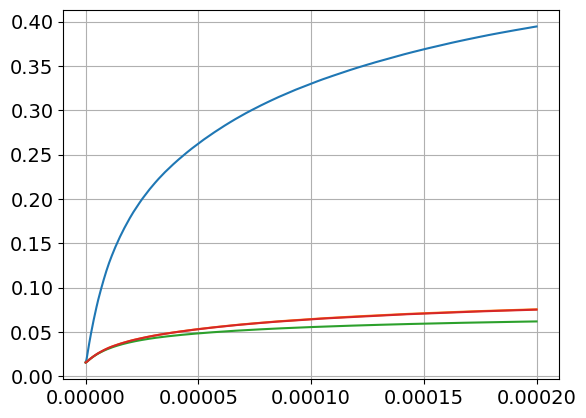

In [46]:
fig, ax = plt.subplots()
ax.plot(sol.t, y[:4, :].T)

ax.grid()


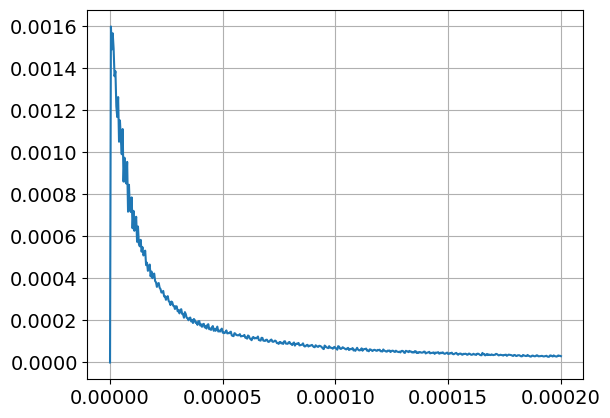

In [47]:
fig, ax = plt.subplots()
ax.plot(sol.t, y[-3, :].T)

ax.grid()


# Dissipator Func Lambdify Numpy

In [48]:
def lindblad_rhs(
    t,
    rho,
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    dissipator_func,
    rows,
    cols,
):
    """
    Compute the right-hand side of the Lindblad master equation, taking
    advantage of the Hermitian nature of the density matrix and Hamiltonian
    using specialized BLAS routines.

    The Lindblad equation is:

        dρ/dt = -i [H, ρ] + ∑_j (L_j ρ L_j† - 0.5 {L_j† L_j, ρ})

    Parameters:
    -----------
    t : float
        Time (included for ODE solver compatibility).
    rho : np.ndarray
        Density matrix (should be Hermitian).
    H_static : np.ndarray
        Hamiltonian (should be Hermitian).
    H_detunings : np.ndarray
        Hamiltonian for each detuning
    H_couplings : np.ndarray
        Coupling hamiltonians
    detunings : np.ndarray
        detunings corresponding to H_detunings
    omegas : np.ndarray
        rabi rates corresponding to the couplings
    dissipator_func : Callable
        function returning the dissipator
    rows : np.ndarray
        row indices of rho to put into dissipator_func
    cols : np.ndarray
        col indices of rho to put into dissipator_func

    Returns:
    --------
    d_rho_dt : np.ndarray
        The time derivative of the density matrix.
    """
    H = np.zeros_like(rho, dtype=np.complex128)
    H = (
        H_static
        + np.sum(H_detunings * detunings[:, np.newaxis, np.newaxis], axis=0)
        + omegas[0] * H_couplings[0][0]
    )
    id1, id2 = get_on_off_indices(t, 1e6)
    H += omegas[1] * H_couplings[1][id1] + omegas[2] * H_couplings[2][id2]

    # Compute the commutator: -i[H, ρ]
    commutator = -1j * (np.dot(H, rho) - np.dot(rho, H))

    return commutator + dissipator_func(*rho[rows, cols])


In [49]:
def vectorized_lindblad_rhs(
    t,
    y,
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    dissipator_func,
    rows,
    cols,
):
    """
    This wrapper converts the flat state vector y back into an n x n density matrix,
    calls lindblad_rhs to compute the time derivative, and then flattens the result.
    """
    n = H_static.shape[0]
    # Reshape the flat vector back into the density matrix.
    rho = y.reshape((n, n))
    # Compute the derivative using your provided function.
    d_rho_dt = lindblad_rhs(
        t,
        rho,
        H_static,
        H_couplings,
        H_detunings,
        omegas,
        detunings,
        dissipator_func,
        rows,
        cols,
    )
    # Flatten the matrix derivative to return a one-dimensional array.
    return d_rho_dt.flatten()


In [50]:
def subscript_to_int(sub_str):
    # Mapping of Unicode subscript digits to normal digits
    subscript_digits = {
        "₀": "0",
        "₁": "1",
        "₂": "2",
        "₃": "3",
        "₄": "4",
        "₅": "5",
        "₆": "6",
        "₇": "7",
        "₈": "8",
        "₉": "9",
    }
    # Convert each subscript character to its normal equivalent and join them
    normal_str = "".join(subscript_digits.get(ch, ch) for ch in sub_str)
    return int(normal_str)


def extract_indices(string):
    """
    Given a string of the form 'ρ₀,₆₄', extract the indices as integers.
    """
    # Remove the first character (assuming it's the symbol, e.g., 'ρ')
    indices_str = string[1:]
    # Split the remaining string by the comma
    parts = indices_str.split(",")
    # Convert each subscript part to an integer
    indices = [subscript_to_int(part) for part in parts]
    return tuple(indices)


In [51]:
free_symbols = list(dissipator.free_symbols)
free_symbols = [
    free_symbols[idx] for idx in np.argsort([str(val) for val in free_symbols])
]

dissipator_func = smp.lambdify(free_symbols, dissipator, modules="numpy")


In [52]:
indices_array = np.array([extract_indices(str(val)) for val in free_symbols])

In [53]:
rows, cols = zip(*indices_array)

In [54]:
%%timeit
dissipator_func(*rho_ini[rows, cols])


506 μs ± 24.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [55]:
%%timeit
vectorized_lindblad_rhs(
    0.0,
    rho_ini.flatten(),
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    dissipator_func,
    rows,
    cols,
)


903 μs ± 22.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [56]:
n = rho.shape[0]

H_couplings = [
    [np.ascontiguousarray(field.field) for field in cpl.fields] for cpl in coupling
]

num, sym = decompose_matrix_numpy(smp.diag(*np.diag(H_symbolic)))

H_static = np.ascontiguousarray(num)
H_detunings = [np.ascontiguousarray(val) for val in sym.values()]

rho_ini = np.ascontiguousarray(np.zeros(rho.shape, dtype=np.complex128))
rho_ini[np.arange(0, n - 3), np.arange(0, n - 3)] = 1 / (n - 3)

detunings = np.zeros(3, dtype=np.float64)
omegas = np.array([hamiltonian.Γ / 2, hamiltonian.Γ / 2, hamiltonian.Γ / 2])

t_span = (0.0, 200e-6)
t_eval = np.linspace(np.min(t_span), np.max(t_span), 101)


In [57]:
sol = integrate.solve_ivp(
    fun=lambda t, y: vectorized_lindblad_rhs(
        t,
        y,
        H_static,
        H_couplings,
        H_detunings,
        omegas,
        detunings,
        dissipator_func,
        rows,
        cols,
    ),
    t_span=t_span,
    t_eval=t_eval,
    y0=rho_ini.flatten(),
    method="RK45",
    rtol=1e-3 / 50,
    atol=1e-5 / 50,
)


In [58]:
y = extract_diagonals(sol.y).real

print(f"{y[0, -1] / y[0, 0]:.2f} gain in J=0, F=0")


25.25 gain in J=0, F=0


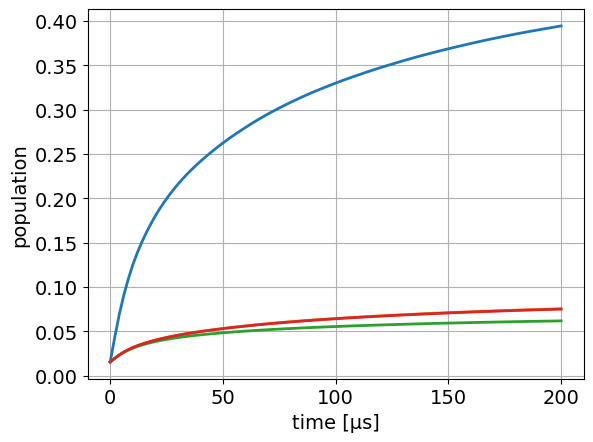

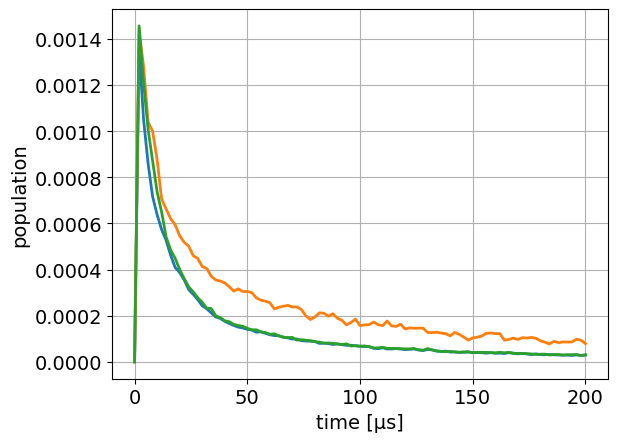

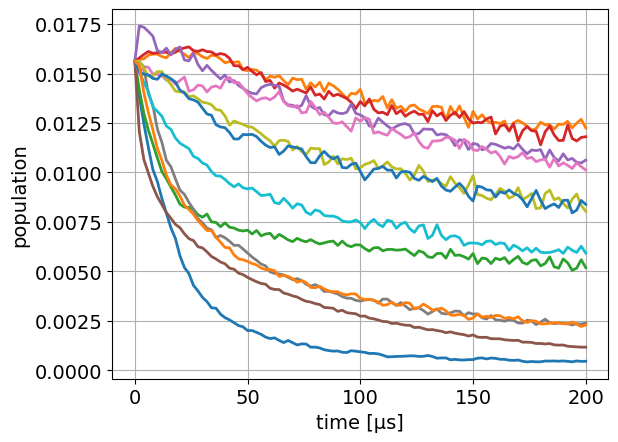

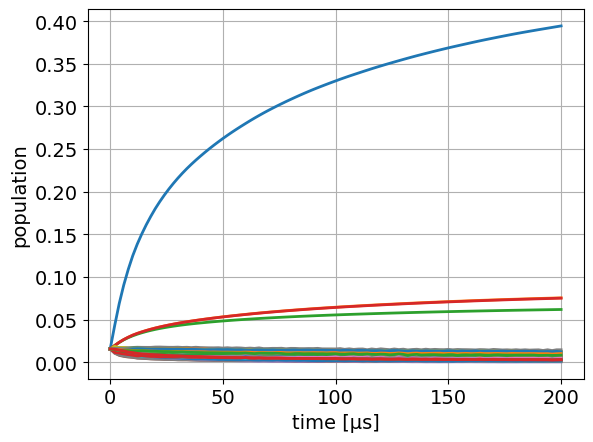

In [59]:
fig, ax = plt.subplots()
ax.plot(sol.t * 1e6, y[:4, :].T, lw=2)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

fig, ax = plt.subplots()
ax.plot(sol.t * 1e6, y[-3:, :].T, lw=2)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

fig, ax = plt.subplots()
ax.plot(
    sol.t * 1e6,
    y[
        utils.population.J_levels(0) : utils.population.J_levels(0)
        + utils.population.J_levels(1),
        :,
    ].T,
    lw=2,
)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

fig, ax = plt.subplots()
ax.plot(sol.t * 1e6, y[:-3, :].T, lw=2)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()


# Dissipator Function Compiled Fortran

In [60]:
import re


# Mapping dictionaries for Greek letters and subscript digits.
greek_map = {
    "α": "alpha",
    "β": "beta",
    "γ": "gamma",
    "δ": "delta",
    "ε": "epsilon",
    "ζ": "zeta",
    "η": "eta",
    "θ": "theta",
    "ι": "iota",
    "κ": "kappa",
    "λ": "lambda",
    "μ": "mu",
    "ν": "nu",
    "ξ": "xi",
    "ο": "omicron",
    "π": "pi",
    "ρ": "rho",
    "σ": "sigma",
    "τ": "tau",
    "υ": "upsilon",
    "φ": "phi",
    "χ": "chi",
    "ψ": "psi",
    "ω": "omega",
}

subscript_map = {
    "₀": "0",
    "₁": "1",
    "₂": "2",
    "₃": "3",
    "₄": "4",
    "₅": "5",
    "₆": "6",
    "₇": "7",
    "₈": "8",
    "₉": "9",
}


def convert_symbol_name(name):
    """
    Convert a symbol name to an ASCII-only version. If the name contains
    commas (e.g. 'ρ₀,₆₄'), treat the pieces after the comma as one contiguous group.
    Desired: 'ρ₀,₆₄' -> 'rho_0_64'
    """
    # Split the name on commas. For "ρ₀,₆₄", parts = ["ρ₀", "₆₄"]
    parts = name.split(",")
    new_parts = []
    for part in parts:
        letter_part = ""
        subscript_part = ""
        for char in part:
            if char in subscript_map:
                subscript_part += subscript_map[char]
            elif char in greek_map:
                letter_part += greek_map[char]
            elif char.isalnum():
                letter_part += char
            else:
                letter_part += "_"
        # If there is a subscript part, append it to the letter part.
        if subscript_part:
            if letter_part:
                new_str = letter_part + "_" + subscript_part
            else:
                new_str = subscript_part
        else:
            new_str = letter_part
        new_parts.append(new_str)
    # Join the parts with an underscore only if there is more than one part.
    return "_".join(new_parts)


def rename_symbols(expr):
    """
    Given a Sympy expression, return a new expression where each free symbol is replaced
    by a new symbol whose name is an ASCII version of the original.

    Returns:
        new_expr: the modified expression.
        rename_dict: a dictionary mapping old symbols to new symbols.
    """
    rename_dict = {}
    for s in expr.free_symbols:
        new_name = convert_symbol_name(s.name)
        # Only change if necessary.
        if new_name != s.name:
            # Preserve assumptions (like complex=True) by passing them to symbols.
            new_sym = smp.symbols(new_name, **s.assumptions0)
            rename_dict[s] = new_sym
    new_expr = expr.subs(rename_dict)
    return new_expr, rename_dict


In [61]:
dissipator_renamed, rename_dict = rename_symbols(dissipator)

In [62]:
indices_sort = np.argsort([str(val) for val in list(rename_dict.keys())])
arguments = [list(rename_dict.values())[idx] for idx in indices_sort]
arguments_complex = [smp.Symbol(val.name, complex=True) for val in arguments]

for arg, argc in zip(arguments, arguments_complex):
    dissipator_renamed = dissipator_renamed.subs(arg, argc)


In [63]:
idx = np.random.choice(range(len(arguments)))
print(arguments_complex[idx], free_symbols[idx])


rho_23_64 ρ₂₃,₆₄


In [64]:
out = smp.MatrixSymbol("out", *H_symbolic.shape)

In [65]:
from sympy.utilities.codegen import codegen
import subprocess
import sys

[(module_name, fortran_code), (header_name, header_code)] = codegen(
    ("dissipator", smp.Equality(out, smp.ImmutableDenseMatrix(dissipator_renamed))),
    language="F95",
    project="dissipator_compiled",
    to_files=False,
    argument_sequence=arguments_complex + [out],
)
fortran_code = fortran_code.replace("REAL*8", "COMPLEX*16")
header_code = header_code.replace("REAL*8", "COMPLEX*16")

with open("dissipator_code.f90", "w") as f:
    f.write(fortran_code)


In [66]:
cmd = [
    sys.executable,
    "-m",
    "numpy.f2py",
    "-c",
    "-m",
    module_name.strip(".f90"),
    "dissipator_code.f90",
]
subprocess.run(cmd, check=True)


In [67]:
import importlib

dissipator_module = importlib.import_module("dissipator")


In [68]:
%%timeit
dissipator_module.dissipator(*rho[rows, cols])


89.6 μs ± 3.39 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [69]:
%%timeit
dissipator_func(*rho[rows, cols])


539 μs ± 19.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [70]:
assert np.allclose(
    dissipator_module.dissipator(*rho[rows, cols]),
    dissipator_func(*rho[rows, cols]),
)


In [71]:
%%timeit
vectorized_lindblad_rhs(
    0.0,
    rho_ini.flatten(),
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    dissipator_module.dissipator,
    rows,
    cols,
)


477 μs ± 8.73 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [72]:
%%timeit
vectorized_lindblad_rhs(
    0.0,
    rho_ini.flatten(),
    H_static,
    H_couplings,
    H_detunings,
    omegas,
    detunings,
    dissipator_func,
    rows,
    cols,
)


913 μs ± 13.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [73]:
n = rho.shape[0]

H_couplings = [
    [np.ascontiguousarray(field.field) for field in cpl.fields] for cpl in coupling
]

num, sym = decompose_matrix_numpy(smp.diag(*np.diag(H_symbolic)))

H_static = np.ascontiguousarray(num)
H_detunings = [np.ascontiguousarray(val) for val in sym.values()]

rho_ini = np.ascontiguousarray(np.zeros(rho.shape, dtype=np.complex128))
rho_ini[np.arange(0, n - 3), np.arange(0, n - 3)] = 1 / (n - 3)

detunings = np.zeros(3, dtype=np.float64)
omegas = np.array([hamiltonian.Γ / 2, hamiltonian.Γ / 2, hamiltonian.Γ / 2])

t_span = (0.0, 200e-6)
t_eval = np.linspace(np.min(t_span), np.max(t_span), 101)


In [74]:
sol = integrate.solve_ivp(
    fun=lambda t, y: vectorized_lindblad_rhs(
        t,
        y,
        H_static,
        H_couplings,
        H_detunings,
        omegas,
        detunings,
        dissipator_module.dissipator,
        rows,
        cols,
    ),
    t_span=t_span,
    t_eval=t_eval,
    y0=rho_ini.flatten(),
    method="RK45",
    rtol=1e-3 / 50,
    atol=1e-5 / 50,
)


In [75]:
y = extract_diagonals(sol.y).real

print(f"{y[0, -1] / y[0, 0]:.2f} gain in J=0, F=0")


25.25 gain in J=0, F=0


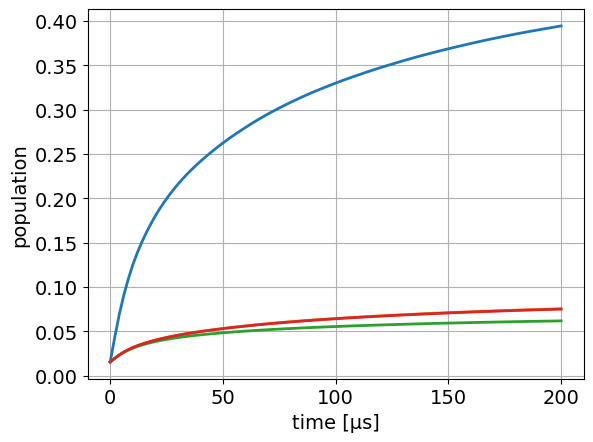

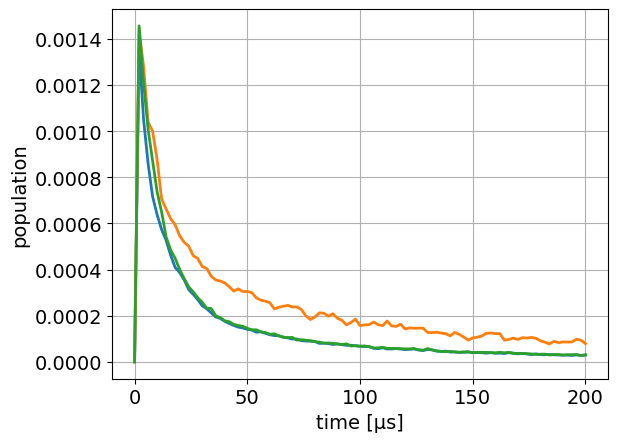

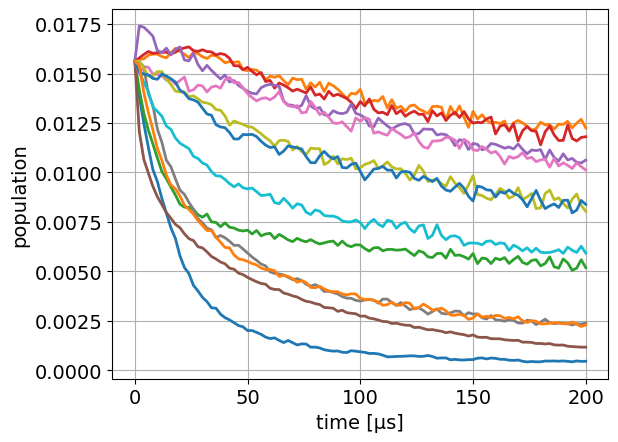

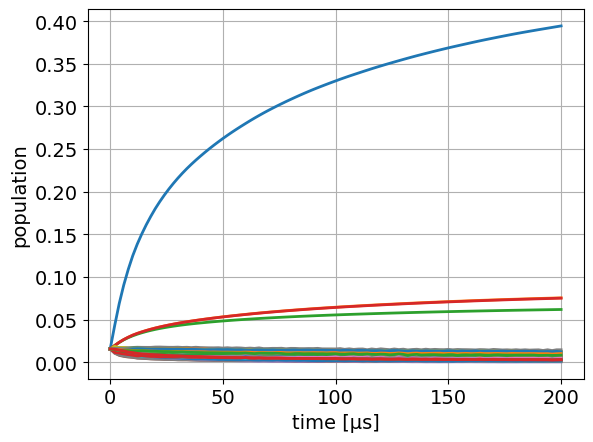

In [76]:
fig, ax = plt.subplots()
ax.plot(sol.t * 1e6, y[:4, :].T, lw=2)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

fig, ax = plt.subplots()
ax.plot(sol.t * 1e6, y[-3:, :].T, lw=2)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

fig, ax = plt.subplots()
ax.plot(
    sol.t * 1e6,
    y[
        utils.population.J_levels(0) : utils.population.J_levels(0)
        + utils.population.J_levels(1),
        :,
    ].T,
    lw=2,
)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()

fig, ax = plt.subplots()
ax.plot(sol.t * 1e6, y[:-3, :].T, lw=2)
ax.set_xlabel("time [μs]")
ax.set_ylabel("population")
ax.grid()
